# The Simpsons characters

## Download the data

In [0]:
!mkdir data
!wget https://www.dropbox.com/s/7mc0xzbtkl0ppwx/simpsons.zip -P ./data/
!unzip ./data/simpsons.zip -d ./data > /dev/null

--2018-06-02 10:43:31--  https://www.dropbox.com/s/7mc0xzbtkl0ppwx/simpsons.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/IdU29T5mdgitrIIeDQed2SsC6pGoYP7DvnxCnqP6cMdnibtiA9NmNoN8qbvi8A1p/file [following]
--2018-06-02 10:43:31--  https://dl.dropboxusercontent.com/content_link/IdU29T5mdgitrIIeDQed2SsC6pGoYP7DvnxCnqP6cMdnibtiA9NmNoN8qbvi8A1p/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.65.6, 2620:100:6021:6::a27d:4106
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.65.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 420348254 (401M) [application/zip]
Saving to: ‘./data/simpsons.zip’

simpsons.zip        100%[===================>] 400.88M  33.5MB/s    in 12s     

2018-06-

In [0]:
!rm ./data/simpsons.zip

Subset of the [Simpsons character Dataset](https://www.kaggle.com/alexattia/the-simpsons-characters-dataset)  

There are about 1000 images in each class, split between the train and validation datasets in the 85:15 ratio.

![alt text](http://crysa.fzu.cz/karla/dl_img/simpsons.png)

## Load libraries

In [0]:
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import numpy as np
from matplotlib import patches, patheffects
import matplotlib
from google.colab import files

In [0]:
from keras import backend as K
from keras.models import Model
from keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import Adam, SGD

Using TensorFlow backend.


In [0]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax
  
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
  
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
           verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [0]:
map_characters = {0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson', 
        3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
        7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
        11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
        14: 'ned_flanders', 15: 'principal_skinner', 16: 'sideshow_bob'}

SZ = 150
BS = 64
num_classes = len(map_characters)

## Transfer learning

Try to train your Simpsons characters classifier on top of of VGG 16.

**Hints: **  
We have 16 different characters, so instead of binary_crossentropy and sigmoid, we are going to use categorical_crossentropy ad softmax.  
The dataset is small, so data augumentation may help.

In [0]:
base_model = VGG16(weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 7s 0us/step


In [0]:
x = base_model.output
x = GlobalAveragePooling2D()(x) # this converts our 3D feature maps to 1D feature vectors
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [0]:
for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer=Adam(lr=1e-3),    
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

In [0]:
train_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=35,  
    width_shift_range=0.1,  
    height_shift_range=0.1, 
    horizontal_flip=True, 
    shear_range=0.1
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)


In [0]:
train_generator = train_datagen.flow_from_directory(
  './data/simpsons/train/',
  target_size=(SZ, SZ),
  batch_size=BS
)

validation_generator = test_datagen.flow_from_directory(
  './data/simpsons/val/',
  target_size=(SZ, SZ),
  batch_size=BS,
  shuffle=False
)


Found 14012 images belonging to 17 classes.
Found 2474 images belonging to 17 classes.


Train your classifier and save its output to a variable.  Tou may need more epochs than 3.
Don't be scared by lower accuracy! We have 17 categories instead of 2. Totally random classifier would have accuracy about 6 %.

In [0]:
%%time
history = model.fit_generator(
    train_generator, 
    train_generator.n // BS, 
    epochs=9, 
    workers=8,
    validation_data=validation_generator, 
    validation_steps=validation_generator.n // BS)

Epoch 1/9
218/218 [==============================] - 124s 569ms/step - loss: 2.3075 - acc: 0.4822 - val_loss: 1.2694 - val_acc: 0.6546
Epoch 2/9
218/218 [==============================] - 124s 569ms/step - loss: 1.1984 - acc: 0.6473 - val_loss: 1.0572 - val_acc: 0.6961
Epoch 3/9
 84/218 [==========>...................] - ETA: 1:10 - loss: 1.0524 - acc: 0.6849

218/218 [==============================] - 125s 572ms/step - loss: 1.0410 - acc: 0.6846 - val_loss: 1.0362 - val_acc: 0.7072
Epoch 4/9
218/218 [==============================] - 124s 569ms/step - loss: 0.9381 - acc: 0.7143 - val_loss: 1.0160 - val_acc: 0.7204
Epoch 5/9
118/218 [===============>..............] - ETA: 51s - loss: 0.8686 - acc: 0.7324

218/218 [==============================] - 122s 559ms/step - loss: 0.8758 - acc: 0.7334 - val_loss: 0.9485 - val_acc: 0.7401
Epoch 6/9
218/218 [==============================] - 121s 554ms/step - loss: 0.8243 - acc: 0.7477 - val_loss: 0.9345 - val_acc: 0.7422
Epoch 7/9
126/218 [================>.............] - ETA: 45s - loss: 0.7473 - acc: 0.7680

218/218 [==============================] - 121s 556ms/step - loss: 0.7704 - acc: 0.7613 - val_loss: 0.9535 - val_acc: 0.7479
Epoch 8/9
218/218 [==============================] - 124s 569ms/step - loss: 0.7453 - acc: 0.7704 - val_loss: 0.9076 - val_acc: 0.7500
Epoch 9/9
128/218 [================>.............] - ETA: 45s - loss: 0.7082 - acc: 0.7795

218/218 [==============================] - 125s 572ms/step - loss: 0.7077 - acc: 0.7792 - val_loss: 0.9621 - val_acc: 0.7360
CPU times: user 32min 40s, sys: 1min 59s, total: 34min 39s
Wall time: 18min 29s


In [0]:
model.save_weights('simpsons_v6gg16_9e.h5') 

In [0]:
#files.download('simpsons_v6gg16_9e.h5')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 58012, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 696, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [0]:
#model.load_weights('simpsons_v6gg16_9e.h5')  #

In [0]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


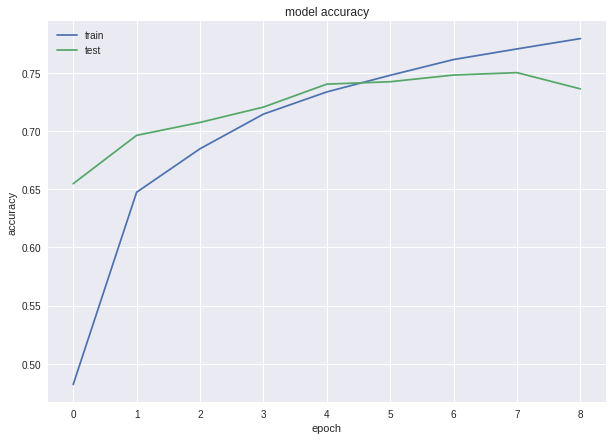

In [0]:
plt.figure(figsize=(10, 7))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc']) 
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

## Check predictions for the validation set

In [0]:
y_true = validation_generator.classes
y_true

array([ 0,  0,  0, ..., 16, 16, 16], dtype=int32)

In [0]:
preds = model.predict_generator(validation_generator)

In [0]:
y_pred = np.argmax(preds, axis=1)

In [0]:
from sklearn.metrics import confusion_matrix
import itertools

In [0]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [0]:
cnf_matrix = confusion_matrix(y_true, y_pred)

[[ 93   1   1   1   1   0   0   3   1   0   1   2   4   1   3   9   1]
 [  0  82   0   1   1   0   0   0   2   1   0   1   1   1   4   3   0]
 [  3   0 126   0   1   0   0   7   2   1   8   5   0   0   5   9   3]
 [  4   1   1 116   1   1   1   3   1   2   3   1   3   1   4  16   1]
 [  4   0   3   3 107   1   0   0   0   1   0   2   0   4   4  11   1]
 [  1   1   1   4   0  68   0   0   3   0   0   0   0   1   2   7   0]
 [  2   0   1   6   0   0  44   3   1   0   0   1   2   2   5   7   2]
 [ 11   2   6  10   1   1   2 109   1   3   5   3   3   2  11  17   1]
 [  1   0   2   1   0   0   0   0  56   0   0   0   0   1   1  10   0]
 [  6   3   2   7   4   1   0   4   0 106   5   3   8   0   4   8   1]
 [  6   0   8   1   2   0   0   0   0   0 156   2   2   0   3   5   3]
 [ 11   0   4   2   2   0   2   7   5   1   4 139   2   1   3   5   1]
 [  6   0   8   6   2   1   1   2   2   0   2   0 112   3   5   5   0]
 [  6   1   1   6   2   0   1   3   2   3   1   0   1 123   3  23   2]
 [  4 

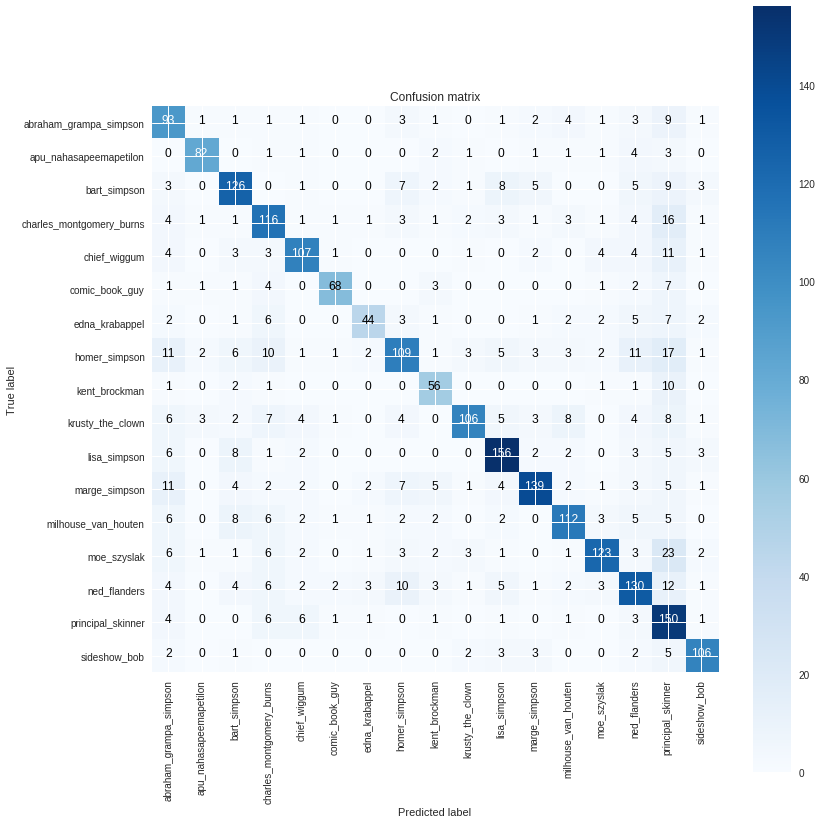

In [0]:
plot_confusion_matrix(cnf_matrix, map_characters.values())


Some correctly predicted images

In [0]:
filenames = validation_generator.filenames

In [0]:
correct = np.where(y_pred == y_true)[0]
idx = np.random.choice(correct, 16, replace=False)

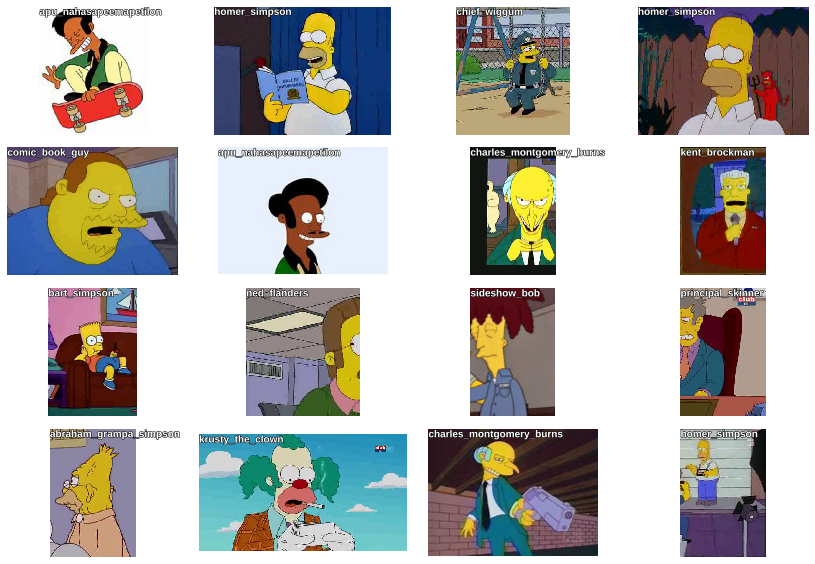

In [0]:
fig, axes = plt.subplots(4, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima = load_img('./data/simpsons/val/'+filenames[idx[i]]) #stayprase
    show_img(ima, ax=ax)
    draw_text(ax, (0,0), map_characters[y_pred[idx[i]]], sz=10)
plt.tight_layout()

...and some incorrectly predicted ones:

In [0]:
incorrect = np.where(y_pred != y_true)[0]
idx = np.random.choice(incorrect, 16, replace=False)

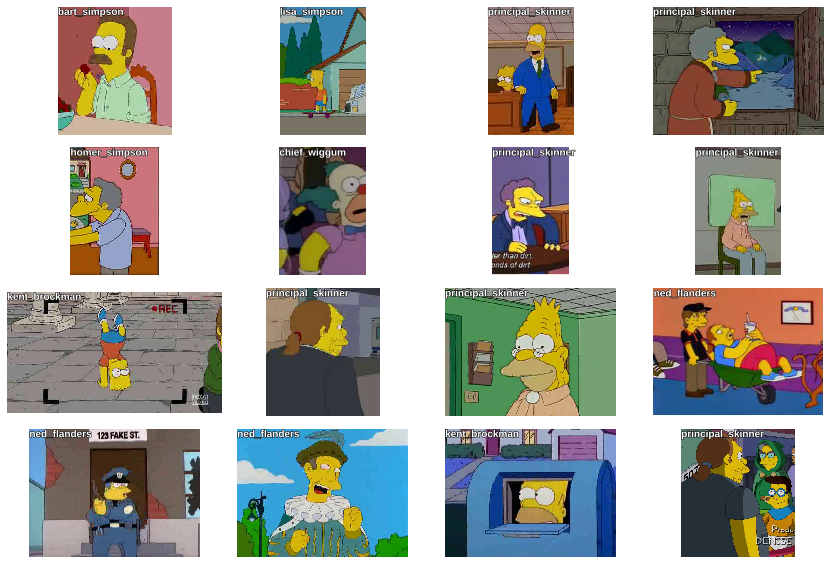

In [0]:
fig, axes = plt.subplots(4, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima = load_img('./data/simpsons/val/'+filenames[idx[i]]) #stayprase
    show_img(ima, ax=ax)
    draw_text(ax, (0,0), map_characters[y_pred[idx[i]]], sz=10)
plt.tight_layout()